# Extract and generate a dataset for specifict cell types 
Norebook to extract units with their putative cell types from allen institute optotagged recordings [https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_optotagging.html]

Cell types are extracted from mice with opsin expressed in these neuron types:
1. Vip
2. Sst
3. Pvalb

Wildtype (no cells are optically tagged) sessions are available here for verification but not included in the resulting dataset

## Download data

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from tqdm import tqdm

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
#where the allen institute data cache will be stored - not the final output of the dataset unless later specified
output_dir = '/mnt/data/noah/allen/optotag_data'

manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [3]:
sessions = cache.get_session_table()

In [4]:
sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


## Extract Sessions from different genotypes

In [5]:
sessions.full_genotype.value_counts()

wt/wt                                              30
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      12
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       8
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     8
Name: full_genotype, dtype: int64

In [6]:
# filter for sessions using laser opposed to LED illumination
mask = sessions.index.values >= 789848216 #sessions below this number were stimulated using LED illumination and had fewer units
sessions_laser = sessions[mask]
print(sessions_laser.full_genotype.value_counts())

wt/wt                                              5
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      5
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      4
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    4
Name: full_genotype, dtype: int64


In [7]:
#these are directories to the data and dont contain data themselves
pvalb_sessions_directory = sessions_laser[sessions.full_genotype.str.match('Pvalb')]
sst_sessions_directory = sessions_laser[sessions.full_genotype.str.match('Sst')]
vip_sessions_directory = sessions_laser[sessions.full_genotype.str.match('Vip')]
wt_sessions_directory = sessions_laser[sessions.full_genotype.str.match('wt')]


/home/noah/miniforge3/envs/optotag2/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/noah/miniforge3/envs/optotag2/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/noah/miniforge3/envs/optotag2/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


### Choose a cell type to extract from
load the directory for a chosen cell type and extract data from one of the listed sessions

In [18]:
#each session and their information for one cell type
pvalb_sessions_directory.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
797828357,2019-10-03T00:00:00Z,776061251,brain_observatory_1.1,107.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,611,2232,6,"[PPT, MB, APN, NOT, HPF, ProS, CA1, VISam, nan..."
829720705,2019-10-03T00:00:00Z,811322619,functional_connectivity,112.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,529,1841,5,"[SCig, SCop, SCsg, SCzo, POST, VISp, nan, CA1,..."
839557629,2019-10-03T00:00:00Z,821469666,functional_connectivity,115.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,450,1853,5,"[APN, NOT, MB, DG, CA1, VISam, nan, VISpm, LGd..."
840012044,2019-10-03T00:00:00Z,820866121,functional_connectivity,116.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,758,2298,6,"[APN, DG, CA1, VISam, nan, LP, VISpm, VISp, LG..."


In [20]:
#extract for one session

#this can take a few mins - just add session number you want here :)
#downloads session data from allen inst cache
session = cache.get_session_data(839557629)

## Extract Spike Times for Units

Units are extracted for displaying an increased firing rate during optical stimulation

This is defined as a firing rate of >=2x the units baseline firing rate during stim

This could likely be improved, particularly for cells with very low stimulated and baseline firing rates

In [22]:
#useful cell for understanding the structure of the session object. Run one line at a time

# ??session
# help(session)
# session.units.ecephys_structure_acronym.unique()
# print(session.__doc__)

In [23]:
columns = ['stimulus_name', 'duration','level']
session.optogenetic_stimulation_epochs.drop_duplicates(columns).sort_values(by=columns).drop(columns=['start_time','stop_time']).shape


(12, 4)

In [24]:
# trials = session.optogenetic_stimulation_epochs[(session.optogenetic_stimulation_epochs.duration > 0.009) & \
#                                                 (session.optogenetic_stimulation_epochs.duration < 0.02)]
trials = session.optogenetic_stimulation_epochs
units = session.units[session.units.ecephys_structure_acronym.str.match('VIS')] #only take units in the visual cortex (others are too deep for stimulation
#units from: vis am, vis pm, vis p, vis l , vis al

time_resolution = 0.0005 # 0.5 ms bins

bin_edges = np.arange(-0.01, 0.025, time_resolution)

In [25]:
def optotagging_spike_counts(bin_edges, trials, units):
    
    time_resolution = np.mean(np.diff(bin_edges))

    spike_matrix = np.zeros( (len(trials), len(bin_edges), len(units)) )

    for unit_idx, unit_id in enumerate(units.index.values):

        spike_times = session.spike_times[unit_id]

        for trial_idx, trial_start in enumerate(trials.start_time.values):

            in_range = (spike_times > (trial_start + bin_edges[0])) * \
                       (spike_times < (trial_start + bin_edges[-1]))

            binned_times = ((spike_times[in_range] - (trial_start + bin_edges[0])) / time_resolution).astype('int')
            spike_matrix[trial_idx, binned_times, unit_idx] = 1
            
    return xr.DataArray(
        name='spike_counts',
        data=spike_matrix,
        coords={
            'trial_id': trials.index.values,
            'time_relative_to_stimulus_onset': bin_edges,
            'unit_id': units.index.values
        },
        dims=['trial_id', 'time_relative_to_stimulus_onset', 'unit_id']
    )

In [26]:
da = optotagging_spike_counts(bin_edges, trials, units)

In [27]:
da.shape # 75 trials, time, units

(300, 70, 219)

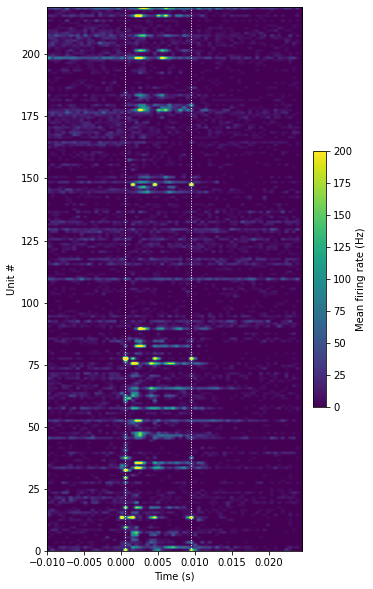

In [29]:
def plot_optotagging_response(da):

    plt.figure(figsize=(5,10))

    plt.imshow(da.mean(dim='trial_id').T / time_resolution, 
               extent=[np.min(bin_edges), np.max(bin_edges),
                       0, len(units)],
               aspect='auto', vmin=0, vmax=200)    

    for bound in [0.0005, 0.0095]:
        plt.plot([bound, bound],[0, len(units)], ':', color='white', linewidth=1.0)

    plt.xlabel('Time (s)')
    plt.ylabel('Unit #')

    cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb.set_label('Mean firing rate (Hz)')
    
plot_optotagging_response(da)

In [33]:
#calculate firing rate:
baseline = da.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002))

baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))

evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

In [34]:
#could use this cell to find instantaneous firing rates...

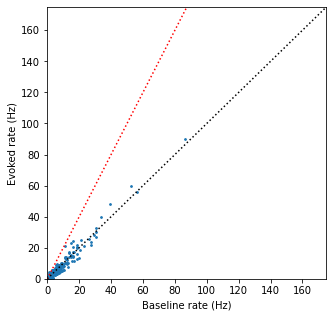

In [35]:
plt.figure(figsize=(5,5))

plt.scatter(baseline_rate, evoked_rate, s=3)

axis_limit = 175
plt.plot([0,axis_limit],[0,axis_limit], ':k')
plt.plot([0,axis_limit],[0,axis_limit*2], ':r')
plt.xlim([0,axis_limit])
plt.ylim([0,axis_limit])

plt.xlabel('Baseline rate (Hz)')
_ = plt.ylabel('Evoked rate (Hz)')

In [ ]:
# select tuned neurons with a z-score? :) 

In [109]:
#unitd are selected with an evoked rate > ((baseline_rate +1) * 2)

cre_pos_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) > 2].values
print(len(cre_pos_units))

66


In [115]:
import numpy as np
cre_waveforms = np.empty((len(cre_pos_units), 82))
for i, unit_id in enumerate(cre_pos_units):
    
    peak_channel = session.units.loc[unit_id].peak_channel_id
    cre_waveforms[i] = (session.mean_waveforms[unit_id].sel(channel_id = peak_channel))

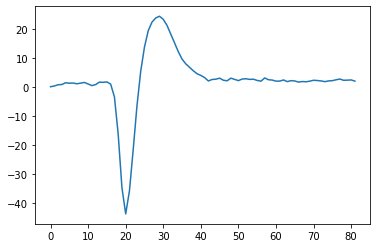

In [120]:
cre_waveforms.shape
plt.plot(cre_waveforms[8])
plt.show()
#these waves are aligned at sample 20 and are 82 samples long. need to adjust for ceed

## Extract all Sessions

Repeat previous steps to extract and create a dataset for all of the celly types accross all sessions

In [41]:
cell_types = ['Sst', 'Vip', 'Pvalb']
session_dict = {}
for cell_type in cell_types:
    session_dict[cell_type] = sessions_laser[sessions.full_genotype.str.match(cell_type)].index.values

/home/noah/miniforge3/envs/optotag2/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [42]:
sessions_laser.loc[840012044]

published_at                                               2019-10-03T00:00:00Z
specimen_id                                                           820866121
session_type                                            functional_connectivity
age_in_days                                                                 116
sex                                                                           M
full_genotype                   Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
unit_count                                                                  758
channel_count                                                              2298
probe_count                                                                   6
ecephys_structure_acronyms    [APN, DG, CA1, VISam, nan, LP, VISpm, VISp, LG...
Name: 840012044, dtype: object

In [43]:
session_dict

{'Sst': array([789848216, 794812542, 831882777, 839068429]),
 'Vip': array([791319847, 798911424, 816200189, 819701982, 835479236]),
 'Pvalb': array([797828357, 829720705, 839557629, 840012044])}

In [ ]:
all_cre_units = {}
all_non_tuned_units = {}
for cell_type in tqdm(cell_types):
    
    cre_units_multi_session = {}
    non_tuned_units_multi_session = {}
    for session_id in tqdm(session_dict[cell_type]):
        session = cache.get_session_data(session_id)
        
        columns = ['stimulus_name', 'duration','level']
        session.optogenetic_stimulation_epochs.drop_duplicates(columns).sort_values(by=columns).drop(columns=['start_time','stop_time']).shape
    
        trials = session.optogenetic_stimulation_epochs
        units = session.units[session.units.ecephys_structure_acronym.str.match('VIS')]
        #units from: vis am, vis pm, vis p, vis l , vis al
        time_resolution = 0.0005 # 0.5 ms bins
        bin_edges = np.arange(-0.01, 0.025, time_resolution)
    
        da = optotagging_spike_counts(bin_edges, trials, units)
    
        #calculate firing rate:
        baseline = da.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002))
        
        baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008
        
        evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))
        
        evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008
    
        cre_pos_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) >= 2].values
        non_tuned_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) < 1.5].values
    
        cre_waveforms = np.empty((len(cre_pos_units), 82))
        cre_positions = []
        for i, unit_id in enumerate(cre_pos_units):
            peak_channel = session.units.loc[unit_id].peak_channel_id
            cre_waveforms[i] = (session.mean_waveforms[unit_id].sel(channel_id = peak_channel))
            cre_positions.append([session.units.probe_horizontal_position.values, session.units.probe_vertical_position.values])

        non_tuned_waveforms = np.empty((len(non_tuned_units), 82))
        non_tuned_positions = []
        for i, unit_id in enumerate(non_tuned_units):
            peak_channel = session.units.loc[unit_id].peak_channel_id
            non_tuned_waveforms[i] = (session.mean_waveforms[unit_id].sel(channel_id = peak_channel))
            non_tuned_positions.append([session.units.probe_horizontal_position.values, session.units.probe_vertical_position.values])
        
        
        cre_units_multi_session[session_id] = {'waveforms' : cre_waveforms, 'unit_ids' : cre_pos_units, 'unit_position' : cre_positions}
        non_tuned_units_multi_session[session_id] = {'waveforms' : non_tuned_waveforms, 'unit_ids' : non_tuned_units, 'unit_positions' : non_tuned_positions}

    all_cre_units[cell_type] = cre_units_multi_session
    all_non_tuned_units[cell_type] = non_tuned_units_multi_session


In [47]:
all_non_tuned_units['Sst'][789848216].keys()

dict_keys(['waveforms', 'unit_ids', 'unit_positions'])

In [48]:
all_cre_units['Sst'].keys()
#between 9 and 50 units per session, vip had sig fewer cells

dict_keys([789848216, 794812542, 831882777, 839068429])

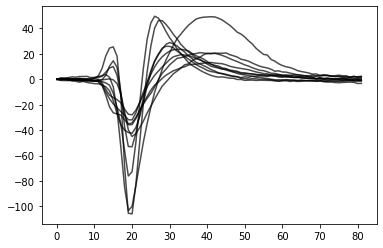

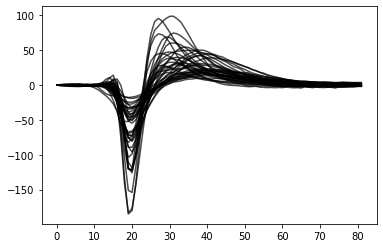

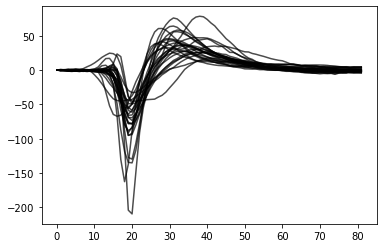

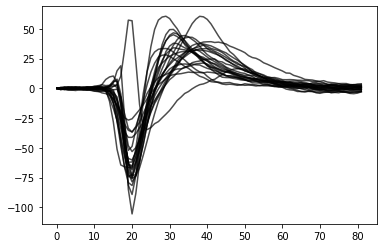

In [49]:
cell_type = 'Sst'
for session_id in all_cre_units[cell_type]:
    for wave in all_cre_units[cell_type][session_id]['waveforms']:
        plt.plot(wave, c = 'k', alpha = 0.7)
    plt.show()

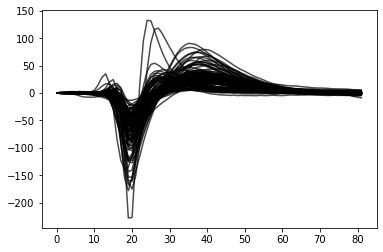

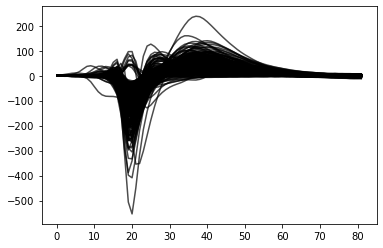

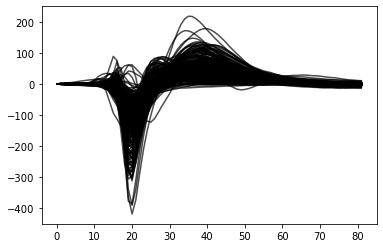

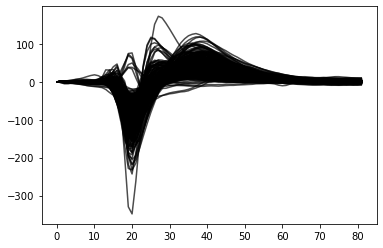

In [50]:
#get a similar dataset of non-tuned neurons:

cell_type = 'Sst'
for session_id in all_non_tuned_units[cell_type]:
    for wave in all_non_tuned_units[cell_type][session_id]['waveforms']:
        plt.plot(wave, c = 'k', alpha = 0.7)
    plt.show()

## Save this data for later analysis
Saved as two dictionaries organised by tuning and mouse genotype (cell type)


In [51]:
# save this data for ceed analysis:
save_path = '/home/noah/noah/allen/optotagging_ceed_dataset/'
non_tuned_df = np.save(save_path+'non_tuned.npy', all_non_tuned_units)
tuned_df = np.save(save_path+'tuned.npy', all_cre_units)